In [1]:
!pip install d2l==0.14.3

     |████████████████████████████████| 61kB 3.6MB/s 


In [2]:
from d2l import torch as d2l
import torch
import torchvision
from torch import nn

In [3]:
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')
data_dir = d2l.download_extract('pokemon')

In [4]:
batch_size = 256
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])
pokemon = torchvision.datasets.ImageFolder(data_dir, transformer)
data_iter = torch.utils.data.DataLoader(
    pokemon, batch_size=batch_size,
    shuffle=True, num_workers=d2l.get_dataloader_workers())

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


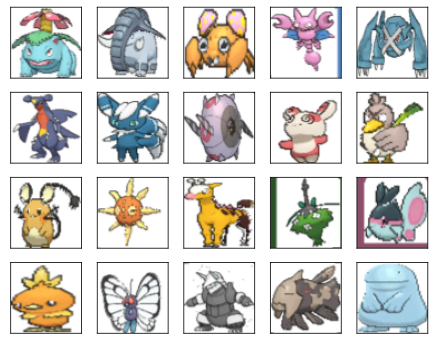

In [5]:
d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[0:20,:,:,:].permute(0, 2, 3, 1)/2+0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break

In [6]:
class G_block(nn.Module):
        def __init__(self, channels, nc=3, kernel_size=4, strides=2,
                 padding=1, alpha=0.2, **kwargs):
            super(G_block, self).__init__(**kwargs)
            self.conv2d = nn.ConvTranspose2d(
                nc, channels, kernel_size, strides, padding, bias=False)
            self.batch_norm = nn.BatchNorm2d(channels)
            self.activation = nn.ReLU(alpha)

        def forward(self, X):
            return self.activation(self.batch_norm(self.conv2d(X)))

In [7]:
x = torch.zeros((2, 3, 16, 16))
g_blk = G_block(20)
g_blk(x).shape

torch.Size([2, 20, 32, 32])

In [8]:
x = torch.zeros((2, 3, 1, 1))
g_blk = G_block(20, strides=1, padding=0)
g_blk(x).shape

torch.Size([2, 20, 4, 4])

In [9]:
def Conv2DTranspose(channels, kernel_size, strides, padding, use_bias, nc=3):
    return nn.ConvTranspose2d(nc, channels, kernel_size=kernel_size,stride=strides, padding=padding, bias=use_bias)

In [10]:
n_G = 64
net_G = nn.Sequential(
    G_block(n_G*8, strides=1, padding=0),  # Output: (64 * 8, 4, 4)
    G_block(n_G*4, n_G*8),  # Output: (64 * 4, 8, 8)
    G_block(n_G*2, n_G*4),  # Output: (64 * 2, 16, 16)
    G_block(n_G, n_G*2),    # Output: (64, 32, 32)
    Conv2DTranspose(
              3, nc=n_G, kernel_size=4, strides=2, padding=1, use_bias=False),
    nn.Tanh()               # Output: (3, 64, 64)
)

In [11]:
x = torch.zeros((1, 3, 1, 1))
net_G(x).shape

torch.Size([1, 3, 64, 64])

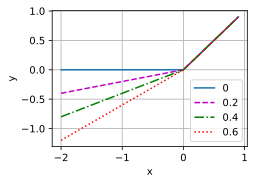

In [12]:
alphas = [0, 0.2, 0.4, .6, .8, 1]
x = torch.arange(-2, 1, 0.1)
Y = [nn.LeakyReLU(alpha)(x).numpy() for alpha in alphas]
d2l.plot(x.numpy(), Y, 'x', 'y', alphas)

In [13]:
class D_block(nn.Module):
        def __init__(self, channels, nc=3, kernel_size=4, strides=2,
                 padding=1, alpha=0.2, **kwargs):
            super(D_block, self).__init__(**kwargs)
            self.conv2d = nn.Conv2d(
                nc, channels, kernel_size, strides, padding, bias=False)
            self.batch_norm = nn.BatchNorm2d(channels)
            self.activation = nn.LeakyReLU(alpha, inplace=True)

        def forward(self, X):
            return self.activation(self.batch_norm(self.conv2d(X)))

In [14]:
x = torch.zeros((2, 3, 16, 16))
d_blk = D_block(20)
d_blk(x).shape

torch.Size([2, 20, 8, 8])

In [15]:
def Conv2D(channels, kernel_size, use_bias, nc=3):
    return nn.Conv2d(nc, channels, kernel_size=kernel_size, bias=use_bias)

In [16]:
n_D = 64
net_D = nn.Sequential(
    D_block(n_D),    # Output: (64, 32, 32)
    D_block(n_D*2, n_D),  # Output: (64 * 2, 16, 16)
    D_block(n_D*4, n_D*2),  # Output: (64 * 4, 8, 8)
    D_block(n_D*8, n_D*4),  # Output: (64 * 8, 4, 4)
    Conv2D(1, nc=n_D*8, kernel_size=4, use_bias=False)  # Output: (1, 1, 1)
)

In [17]:
x = torch.zeros((1, 3, 64, 64))
net_D(x).shape

torch.Size([1, 1, 1, 1])

In [18]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim, device=d2l.try_gpu()):
    loss = nn.BCELoss()
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    net_D.zero_grad()
    net_G.zero_grad()
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr, betas=(0.5, 0.5))
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr, betas=(0.5, 0.5))
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                       update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
            # Show generated examples
            Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1))        
            # Normalize the synthetic data to N(0, 1)
            fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
            imgs = np.concatenate(
            [np.concatenate([fake_x[i * 7 + j] for j in range(7)], axis=1)
             for i in range(len(fake_x)//7)], axis=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs.numpy())
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

In [19]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):  #@save
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = torch.ones(batch_size)
    zeros = torch.zeros(batch_size)
    trainer_D.zero_grad()
    real_Y = net_D(X)
    fake_X = net_G(Z)
    # Do not need to compute gradient for `net_G`, detach it from
    # computing gradients.
    fake_Y = net_D(fake_X.detach())
    loss_D = (loss(real_Y, ones) + loss(fake_Y, zeros)) / 2
    loss_D.backward()
    trainer_D.step()
    return loss_D

In [20]:
def update_G(Z, net_D, net_G, loss, trainer_G):  #@save
    """Update generator."""
    batch_size = Z.shape[0]
    ones = torch.ones(batch_size)
    trainer_G.zero_grad()
    # We could reuse `fake_X` from `update_D` to save computation
    fake_X = net_G(Z)
    # Recomputing `fake_Y` is needed since `net_D` is changed
    fake_Y = net_D(fake_X)
    loss_G=loss(fake_Y,ones)
    loss_G.backward()
    trainer_G.step()
    return loss_G

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


RuntimeError: ignored

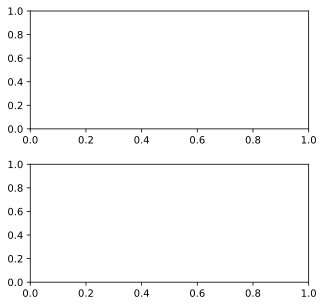

In [21]:
latent_dim, lr, num_epochs = 3, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

pass images to device also.
https://discuss.pytorch.org/t/input-type-torch-floattensor-and-weight-type-torch-cuda-floattensor-should-be-the-same/48633/2
`images,labels = images.to(device),labels.to(device)`

In [22]:
imgs = imgs.to(device)

NameError: ignored

In [23]:
device=d2l.try_gpu()

In [24]:
imgs = imgs.to(device)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


RuntimeError: ignored

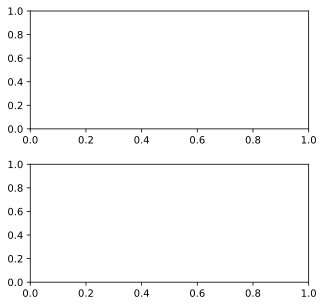

In [25]:
latent_dim, lr, num_epochs = 3, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

.to(device)

In [26]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim, device=d2l.try_gpu()):
    loss = nn.BCELoss()
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    net_D.zero_grad()
    net_G.zero_grad()
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr, betas=(0.5, 0.999))
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr, betas=(0.5, 0.999))
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                       update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
            # Show generated examples
            Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1))
            Z = Z.to(device)      
            # Normalize the synthetic data to N(0, 1)
            fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
            imgs = np.concatenate(
            [np.concatenate([fake_x[i * 7 + j] for j in range(7)], axis=1)
             for i in range(len(fake_x)//7)], axis=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs.numpy())
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


RuntimeError: ignored

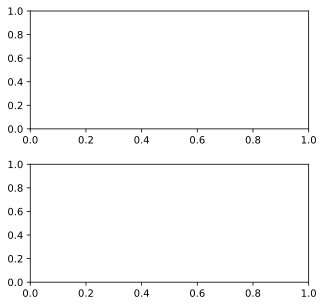

In [27]:
latent_dim, lr, num_epochs = 3, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

In [29]:
net_D, net_G = net_D.to(device), net_G.to(device)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should

RuntimeError: ignored

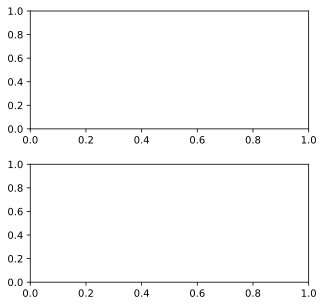

In [30]:
latent_dim, lr, num_epochs = 3, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

In [31]:
update_D,update_G = update_D.to(device),update_G.to(device)

AttributeError: ignored

https://discuss.pytorch.org/t/expected-device-cuda-0-but-got-device-cpu-though-the-two-tensors-are-on-cuda/60180/3%20

just move everything to cuda

In [32]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


RuntimeError: ignored

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


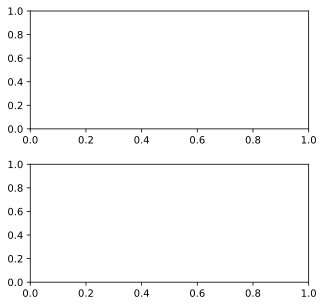

In [33]:
latent_dim, lr, num_epochs = 3, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

In [34]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim, device=d2l.try_gpu()):
    loss = nn.BCELoss()
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    net_D.zero_grad()
    net_G.zero_grad()
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr, betas=(0.5, 0.999))
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr, betas=(0.5, 0.999))
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                       update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
            # Show generated examples
            Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1))
            Z = Z.to(device)      
            # Normalize the synthetic data to N(0, 1)
            fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
            imgs = np.concatenate(
            [np.concatenate([fake_x[i * 7 + j] for j in range(7)], axis=1)
             for i in range(len(fake_x)//7)], axis=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs.numpy())
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


RuntimeError: ignored

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


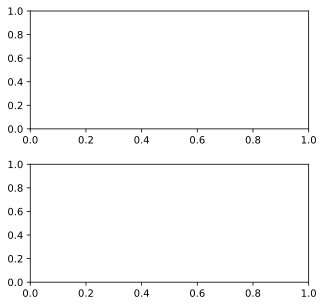

In [35]:
latent_dim, lr, num_epochs = 3, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)